In [146]:
# https://github.com/statsbomb/open-data
# https://github.com/wswager/womens_soccer_expected_goals_model/blob/main/data_preprocessing/expected_goals_data_preprocessing_notebook.ipynb
# https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/tree/master
# https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html
# https://www.youtube.com/watch?v=310_eW0hUqQ&ab_channel=FriendsofTracking

from statsbombpy import sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix

In [255]:
pases = pd.read_csv('archivos/pasesFiltrados_statsbomb.csv')
locations = pd.read_excel('archivos/locations.xlsx')

In [256]:
pases.shape, locations.shape

((282379, 14), (282379, 5))

In [257]:
pases = pd.concat([pases,locations], axis=1)

In [258]:
pases.columns

Index(['Unnamed: 0', 'pass_angle', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_length', 'pass_inswinging', 'pass_outswinging',
       'pass_straight', 'pass_through_ball', 'pass_type', 'play_pattern',
       'pass_height', 'pass_goal_assist', 'Unnamed: 0', 'x', 'y', 'end_x',
       'end_y'],
      dtype='object')

In [259]:
booleanos = pd.Series(pases.columns).str.contains('pass')
df_test = pd.concat([pd.Series(pases.columns), booleanos], axis=1)
df_test[df_test.iloc[:,1] == True]

,0,1
1,pass_angle,True
2,pass_body_part,True
3,pass_cross,True
4,pass_cut_back,True
5,pass_length,True
6,pass_inswinging,True
7,pass_outswinging,True
8,pass_straight,True
9,pass_through_ball,True
10,pass_type,True


In [260]:
#Filtro por las columnas que me sirvan
pases_filt = pases[['pass_angle',             
'pass_body_part',               
'pass_cross',            
'pass_length',    
'pass_through_ball',                 
'play_pattern',
'pass_height',
'pass_goal_assist',
'pass_type',
'x',
'y',
'end_x',
'end_y'
]].reset_index(drop=True)

#Agrego columnas y modifico ciertas otras
pases_filt.pass_cross = pases_filt.pass_cross.fillna(False)
pases_filt.pass_through_ball = pases_filt.pass_through_ball.fillna(False)
pases_filt.pass_goal_assist = pases_filt.pass_goal_assist.fillna(False)
pases_filt.pass_body_part = pases_filt.pass_body_part.fillna('Unknown')
pases_filt.pass_type = pases_filt.pass_type.fillna('Unknown')


In [261]:
pases_filt.play_pattern.value_counts()

Regular Play      127409
From Throw In      73774
From Free Kick     35440
From Goal Kick     18267
From Kick Off      10435
From Corner         8650
From Keeper         5882
From Counter        2211
Other                311
Name: play_pattern, dtype: int64

In [297]:
pases_filt

,pass_angle,pass_body_part,pass_cross,pass_length,pass_through_ball,play_pattern,pass_height,pass_goal_assist,pass_type,x,y,end_x,end_y
0,1.740575,Right Foot,False,3.551056,False,From Kick Off,Ground Pass,False,Kick Off,61.0,40.1,60.4,43.6
1,-2.989549,Right Foot,False,12.544720,False,From Kick Off,Ground Pass,False,Unknown,60.4,43.6,48.0,41.7
2,1.867047,Left Foot,False,35.966790,False,From Kick Off,Ground Pass,False,Unknown,48.0,41.7,37.5,76.1
3,-2.120081,Right Foot,False,19.345800,False,From Kick Off,Ground Pass,False,Unknown,37.5,74.6,27.4,58.1
4,1.064920,Right Foot,False,15.890248,False,From Kick Off,Ground Pass,False,Unknown,27.4,63.9,35.1,77.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282374,0.661043,Head,False,12.541929,False,From Counter,Low Pass,False,Recovery,21.1,37.3,31.0,45.0
282375,-0.989015,Right Foot,False,17.833956,False,From Counter,Ground Pass,False,Unknown,52.0,53.4,61.8,38.5
282376,1.518895,Right Foot,False,7.710382,False,Regular Play,Ground Pass,False,Unknown,53.5,57.9,53.9,65.6
282377,-0.349607,Left Foot,False,10.218122,False,Regular Play,Low Pass,False,Unknown,63.6,10.1,73.2,6.6


In [264]:
from sklearn.pipeline import Pipeline

y = pases_filt['pass_goal_assist']
X = pases_filt.drop(['pass_goal_assist', 'pass_angle'],
                      axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 13)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['pass_body_part', 'play_pattern', 'pass_height', 'pass_type']),
    ],
    remainder='passthrough'  # Mantener las variables numéricas sin modificar
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [298]:
pases_filt.pass_goal_assist.value_counts(normalize=True)

False    0.997631
True     0.002369
Name: pass_goal_assist, dtype: float64

In [266]:
probabilities = model.predict_proba(X)[:, 1]
probabilities = pd.DataFrame(probabilities, columns=['xA'])
X_with_prob = pd.concat([X.reset_index(drop=True), probabilities], axis=1)

In [267]:
X_with_prob.head()

,pass_body_part,pass_cross,pass_length,pass_through_ball,play_pattern,pass_height,pass_type,x,y,end_x,end_y,xA
0,Right Foot,False,3.551056,False,From Kick Off,Ground Pass,Kick Off,61.0,40.1,60.4,43.6,0.000811
1,Right Foot,False,12.544720,False,From Kick Off,Ground Pass,Unknown,60.4,43.6,48.0,41.7,0.000157
2,Left Foot,False,35.966790,False,From Kick Off,Ground Pass,Unknown,48.0,41.7,37.5,76.1,0.000044
3,Right Foot,False,19.345800,False,From Kick Off,Ground Pass,Unknown,37.5,74.6,27.4,58.1,0.000029
4,Right Foot,False,15.890248,False,From Kick Off,Ground Pass,Unknown,27.4,63.9,35.1,77.8,0.000041


In [268]:
pases_filt.pass_goal_assist.sum(), X_with_prob.xA.sum()

(669, 654.4323062607591)

In [269]:
from mplsoccer import FontManager
URL_font = 'https://github.com/google/fonts/blob/main/ofl/fjallaone/FjallaOne-Regular.ttf?raw=true'
robotto_regular = FontManager(URL_font)

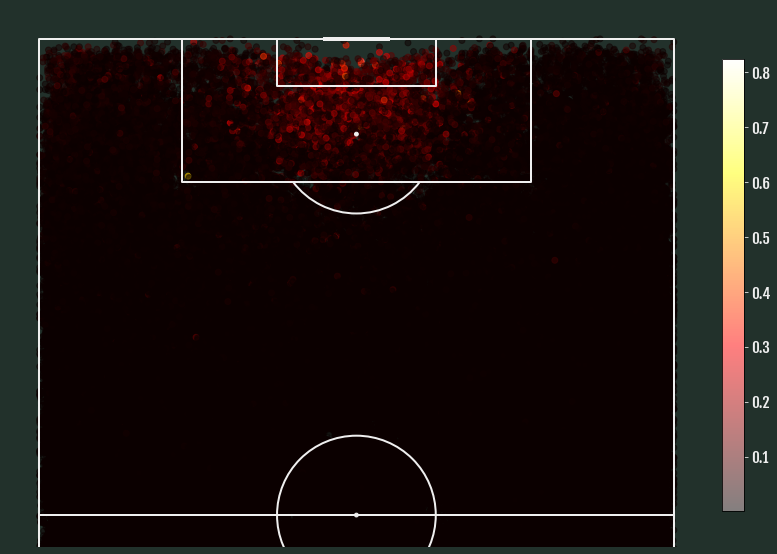

In [299]:
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef', half=True)
fig, ax = pitch.draw(figsize=(10, 8))
fig.set_facecolor('#22312b')
#bs = pitch.bin_statistic(df_xG_tot.start_x, df_xG_tot.start_y, bins=(12, 8))
#heatmap = pitch.heatmap(bs, edgecolors='#122c3d', ax=ax, cmap=pearl_earring_cmap_100)
pcm = pitch.scatter(X_with_prob.end_x, X_with_prob.end_y, c=X_with_prob['xA'], ax=ax, alpha=.5, cmap='hot')
ax_cbar = fig.add_axes((1.008, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cmap='hot', cax=ax_cbar)
cbar.ax.yaxis.set_tick_params(color='#efefef')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(robotto_regular.prop)
    label.set_fontsize(15)

In [300]:
X_with_prob.sort_values(by='xA', ascending=False).head(20)

,pass_body_part,pass_cross,pass_length,pass_through_ball,play_pattern,pass_height,pass_type,x,y,end_x,end_y,xA
36407,Left Foot,True,16.748732,True,From Counter,Ground Pass,Unknown,113.7,24.2,117.1,40.6,0.825160
69653,Left Foot,True,35.750244,True,From Goal Kick,High Pass,Unknown,90.5,15.8,113.7,43.0,0.595789
193927,Left Foot,False,12.432618,True,From Counter,Low Pass,Unknown,93.1,26.7,102.7,18.8,0.559853
62156,Right Foot,True,18.808775,False,From Counter,Low Pass,Unknown,111.5,58.7,115.4,40.3,0.533026
118092,Left Foot,True,32.007656,False,From Counter,High Pass,Unknown,93.5,67.0,111.0,40.2,0.532575
207974,Left Foot,True,30.194370,False,From Counter,High Pass,Unknown,97.2,72.6,110.1,45.3,0.520323
20268,Right Foot,True,14.000000,False,From Counter,High Pass,Unknown,110.0,59.6,110.0,45.6,0.500830
92110,Right Foot,True,21.455536,False,From Counter,High Pass,Unknown,104.7,18.1,113.2,37.8,0.499581
120047,Left Foot,True,28.089321,True,From Free Kick,High Pass,Unknown,98.9,66.7,111.9,41.8,0.499175
167455,Left Foot,True,32.000000,False,From Counter,High Pass,Unknown,89.7,66.2,108.9,40.6,0.496994


In [272]:
X_with_prob.corr()

,pass_cross,pass_length,pass_through_ball,x,y,end_x,end_y,xA
pass_cross,1.000000,0.105308,0.004047,0.174284,0.005828,0.172826,-0.000056,0.703702
pass_length,0.105308,1.000000,0.044413,-0.263210,0.008457,0.010121,0.016643,0.074944
pass_through_ball,0.004047,0.044413,1.000000,0.027199,0.002565,0.069685,0.002002,0.243051
x,0.174284,-0.263210,0.027199,1.000000,0.014999,0.813033,0.010358,0.244925
y,0.005828,0.008457,0.002565,0.014999,1.000000,0.016794,0.757177,-0.019913
end_x,0.172826,0.010121,0.069685,0.813033,0.016794,1.000000,0.013836,0.271078
end_y,-0.000056,0.016643,0.002002,0.010358,0.757177,0.013836,1.000000,-0.028638
xA,0.703702,0.074944,0.243051,0.244925,-0.019913,0.271078,-0.028638,1.000000


In [290]:
partido = sb.events(match_id=3869685)
partido[['end_x', 'end_y']] = partido['pass_end_location'].apply(pd.Series)
partido[['x', 'y']] = partido['location'].apply(pd.Series)


credentials were not supplied. open data access only


In [291]:
partido = partido[(partido['type'] == 'Pass') & (partido['pass_outcome'].isna() == False)]

In [292]:
#Filtro por las columnas que me sirvan
pases_partido = partido[[             
'pass_body_part',               
'pass_cross',
'pass_length',              
'pass_through_ball',                 
'play_pattern',
'pass_height',
'pass_type',
'x',
'y',
'end_x',
'end_y'
]].reset_index(drop=True)

#Agrego columnas y modifico ciertas otras
pases_partido['pass_cross'] = pases_partido['pass_cross'].fillna(False)
pases_partido['pass_through_ball'] = pases_partido['pass_through_ball'].fillna(False)
pases_partido.pass_body_part = pases_partido.pass_body_part.fillna('Unknown')
pases_partido.pass_type = pases_partido.pass_type.fillna('Unknown')

In [293]:
probabilities_partido = model.predict_proba(pases_partido)[:, 1]
probabilities_partido = pd.DataFrame(probabilities_partido, columns=['xA'])
partido_with_prob = pd.concat([pases_partido.reset_index(drop=True), probabilities_partido], axis=1)

In [294]:
partido_with_prob

,pass_body_part,pass_cross,pass_length,pass_through_ball,play_pattern,pass_height,pass_type,x,y,end_x,end_y,xA
0,Right Foot,False,62.377320,False,From Kick Off,High Pass,Unknown,49.7,43.6,96.0,1.8,0.004569
1,Right Foot,False,57.366280,False,From Free Kick,High Pass,Unknown,3.9,43.4,53.1,72.9,0.000053
2,Left Foot,False,26.320524,False,Regular Play,Ground Pass,Unknown,73.2,4.0,47.1,7.4,0.000205
3,Left Foot,True,41.897137,False,From Throw In,High Pass,Unknown,116.0,8.9,104.9,49.3,0.036689
4,Right Foot,False,15.122170,True,From Throw In,High Pass,Unknown,96.7,49.8,110.9,44.6,0.073300
...,...,...,...,...,...,...,...,...,...,...,...,...
264,Left Foot,False,18.700268,True,From Throw In,High Pass,Unknown,74.1,34.6,92.2,29.9,0.041362
265,Left Foot,False,62.346210,False,From Free Kick,High Pass,Free Kick,22.7,50.8,85.0,53.2,0.001243
266,Unknown,False,25.277065,False,From Free Kick,High Pass,Recovery,35.1,26.9,58.4,36.7,0.000037
267,Left Foot,False,71.733955,False,From Goal Kick,High Pass,Goal Kick,6.0,36.0,73.6,60.0,0.000891


In [295]:
pd.concat([partido.reset_index(drop=True), partido_with_prob], axis=1).groupby('player').sum()['xA'].sort_values(ascending=False)

player
Marcos Javier Acuña                0.465969
Kylian Mbappé Lottin               0.457221
Lionel Andrés Messi Cuccittini     0.326781
Rodrigo Javier De Paul             0.312629
Theo Bernard François Hernández    0.312167
Kingsley Coman                     0.252788
Antoine Griezmann                  0.249340
Gonzalo Ariel Montiel              0.240595
Enzo Fernandez                     0.219685
Ángel Fabián Di María Hernández    0.142304
Nicolás Alejandro Tagliafico       0.141695
Adrien Rabiot                      0.105617
Jules Koundé                       0.095649
Marcus Thuram                      0.051716
Dayotchanculle Upamecano           0.038211
Aurélien Djani Tchouaméni          0.035431
Hugo Lloris                        0.028213
Nahuel Molina Lucero               0.024735
Paulo Bruno Exequiel Dybala        0.017782
Ousmane Dembélé                    0.015530
Julián Álvarez                     0.015429
Damián Emiliano Martínez           0.012368
Alexis Mac Allister      

In [ ]:
pd.concat([partido.reset_index(drop=True), partido_with_prob], axis=1)

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,...,y,pass_body_part,pass_length,play_pattern,x,y,end_x,end_y,pass_type,xA
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.1,Left Foot,13.364505,From Kick Off,61.0,40.1,48.0,43.2,Ground Pass,0.000120
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.6,Right Foot,62.377320,From Kick Off,49.7,43.6,96.0,1.8,High Pass,0.004854
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,Unknown,14.139661,From Throw In,22.7,80.0,36.0,75.2,Low Pass,0.000013
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.9,Right Foot,21.062288,From Free Kick,41.1,73.9,23.2,62.8,Ground Pass,0.000007
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.4,Right Foot,27.387589,From Free Kick,24.7,59.4,21.5,32.2,Ground Pass,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.6,Right Foot,20.056171,Regular Play,109.3,61.6,110.8,41.6,Cross - High Pass,0.118155
1259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.0,Left Foot,71.733955,From Goal Kick,6.0,36.0,73.6,60.0,High Pass,0.000162
1260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.1,Left Foot,16.984993,From Goal Kick,46.5,20.1,62.5,25.8,Low Pass,0.000291
1261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.3,Right Foot,10.444615,From Goal Kick,47.1,27.3,56.1,22.0,Ground Pass,0.000127
